In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
# 시작점, 끝점을 하나의 넘파이로 합쳐놓기(테스트를 위해 시작점 2를 삽입없이 합치는 기능도 넣음)
def start_end_marge (end_point, start_point_1, start_point_2 = False):
    n = 2
    SE = np.array([])
    SE = np.append(SE, end_point)
    SE = np.append(SE, start_point_1)
    if (start_point_2 != False):
        SE = np.append(SE, start_point_2)
        n = 3
    SE = np.reshape(SE, (n, 2))
        
    return SE, n

In [3]:
#input_spot = int(input('input_spot(int) : '))
#input_range = float(input('input_range(float) : '))
#input_eps = float(input('input_eps(float) : '))
#input_min = int(input('input_min(int) : '))
input_spot = 100
input_range = 20
input_eps = 0
input_min  = 0

start_point_1 = [0.0, 0.0]
start_point_2 = [0.0, 0.0]
end_point = [200.0, 200.0]

SE, SE_n = start_end_marge(end_point, start_point_1)

# 랜덤 스팟 생성

In [4]:
def make_random_spot (input_spot, min_range, max_range, rseed=None):
    if(rseed != None):
        np.random.seed(rseed)
        
    var = ['X', 'Y']
    labels=['spot0']
    for i in range(0,input_spot-1):
        z = 'spot'+str(i+1)
        labels.append(z)
        
    X = (max_range - min_range) * np.random.random_sample([input_spot,2]) + min_range
    df = pd.DataFrame(X, columns = var, index = labels)
    
    return labels, X, df

In [5]:
labels, X, df = make_random_spot(input_spot, 0, 200, 111)

# 군집 전 랜덤 스팟 출력
삭제해도 괜찮지만 스팟 번호 확인, 전체 스팟의 초기 상태를 확인 할 수 있는 그래프임

'for i in range(0,input_spot):\n    if(i == 0):\n        str_val = "%s"%(labels[i])\n    else:\n        str_val = "0"\n    plt.text(X[i,0]+0.5, X[i,1], str_val, fontsize=9, color=\'black\',\n             horizontalalignment = \'left\', verticalalignment = \'top\')'

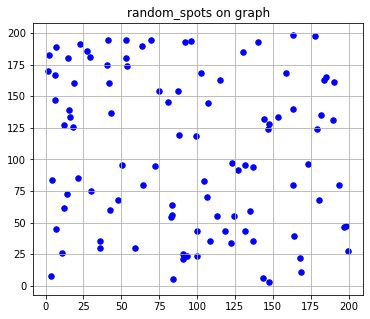

In [6]:
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.title('random_spots on graph')
plt.scatter(X[:,0], X[:,1], c = 'blue', marker = 'o', s = 30)
plt.grid(True)

#점에 번호 붙여주는 기능↓ 나중에 주석 제거해서 사용가능
"""for i in range(0,input_spot):
    str_val = "(%.1f,%.1f)-%s"%(X[i,0], X[i,1], labels[i])
    plt.text(X[i,0]+0.5, X[i,1], str_val, fontsize=9, color='black',
             horizontalalignment = 'left', verticalalignment = 'center')"""

"""for i in range(0,input_spot):
    if(i == 0):
        str_val = "%s"%(labels[i])
    else:
        str_val = "0"
    plt.text(X[i,0]+0.5, X[i,1], str_val, fontsize=9, color='black',
             horizontalalignment = 'left', verticalalignment = 'top')"""

# DBSCAN 노이즈 계산

In [7]:
def make_DBSCAN (input_eps, input_min, df_dbscan, visualization = False):
    if((input_eps == 0) or (input_min == 0)):
        input_eps = 0.21
        input_min = 2
    
    scaler_ss = StandardScaler().fit(df_dbscan)
    x_scaled_ss = scaler_ss.transform(df_dbscan) 
    dbscan = DBSCAN(eps = input_eps, min_samples = input_min)
    clusters_ss = dbscan.fit_predict(x_scaled_ss)
    
    length = len(format(np.unique(clusters_ss)))
    
    # visualization = True 입력할때만 출력해주고 default는 출력 없음
    if(visualization == True):  
        df_np = np.hstack([df_dbscan, clusters_ss.reshape(-1, 1)]) # x_scaled_ss 오른쪽에 1열 붙이기
        
        for i in range(length):
            df_ft = df_np[df_np[:,2]==i, :]
            plt.scatter(df_ft[:, 0], df_ft[:, 1], cmap='PuOr', alpha = 0.8)
            
        # 노이즈 출력
        df_ft1 = df_np[df_np[:,2]==-1, :]
        plt.scatter(df_ft1[:, 0], df_ft1[:, 1], color = 'black')
        
        # ar은 노이즈로 분류된 점들의 첫 인덱스 번호를 가지고 있음
        ar = []
        for i in range(len(df)):
            if(df_np[i,2]==-1):
                ar.append(i)
        
        plt.grid(True)
        plt.show()
    
    return ar

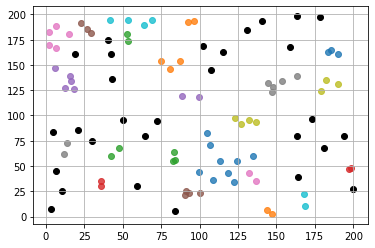

노이즈들 인덱스(ar) ->
 [2, 3, 10, 11, 12, 13, 17, 20, 27, 28, 29, 39, 41, 46, 49, 55, 56, 59, 66, 68, 72, 78, 79, 84, 85, 87, 89, 91, 99]


In [8]:
# dbscan에서 사용하기 위한 df의 값 복사본(데이터프레임 -> 리스트)을 함수 인자로 넣어줌
ar = make_DBSCAN(input_eps, input_min, df.values, True)
drop_len = len(ar)

print('노이즈들 인덱스(ar) ->\n',ar)

# 계산된 노이즈들을 군집에서 제외

In [9]:
def delete_noise (drop_df, ar ,drop_len):
    drop_list = np.array([])
    # drop_df = 노이즈 삭제 된 df
    # drop_list = 삭제 된 노이즈들 모인 list
    
    for i in range(drop_len):
        drop_list = np.append(drop_list, drop_df.values[ar[i]-i])
        sp = 'spot'+str(ar[i])
        drop_df = drop_df.drop([sp])
    
    drop_list = np.reshape(drop_list, (drop_len, 2))
    new_X = drop_df.values 
    # new_X = 마지막에서 좌표 출력할 때 사용될 랜덤 좌표계(노이즈 제거)
    
    new_labels = labels.copy()
    for i in range(len(ar)):
        a= 'spot'+str(ar[i])
        new_labels.remove(a)
    
    return new_X, drop_df, drop_list, new_labels

In [10]:
new_X, drop_df, drop_list, new_labels = delete_noise(df, ar, drop_len)

#=====================================================삭제요망
'''
in_df = drop_df.values[0]
drop_list.append(in_df)
sp = 'spot'+str(0)
drop_df = drop_df.drop([sp])

print(df)
print(drop_list)
print(drop_df)
'''

print(len(labels))
print(len(new_labels))

100
71


# 군집 + 덴드로그램 출력

In [11]:
def hierarchical_dendrogram(drop_df, new_labels, input_spot=0, drop_len=0, 
                            row_dist_print=False, a_print=False, dendrogram_print=False):
    
    distmatrix = pdist(drop_df, metric = 'euclidean')
    row_dist = pd.DataFrame(squareform(distmatrix), columns = new_labels, index = new_labels)
    
    if((input_spot + drop_len) == 0):
        print('row_dist 반환')
        return row_dist
    
    row_clusters = linkage(distmatrix, method = 'average')
    
    if(row_dist_print == True):
        print_col = row_dist.iloc[:5,:5]
        print(print_col)
        
    if(a_print == True):
        a=pd.DataFrame(row_clusters,
            columns=['클러스터ID_1', '클러스터ID_2', '거리', '클러스터 멤버수'],
            index = ['클러스터 %d' %(i+input_spot-drop_len) for i in range(row_clusters.shape[0])])
        print(a[:5])
        
    if(dendrogram_print == True):
        plt.figure(figsize=(25,5))
        plt.subplot(121)
        plt.title('dendrogram')
        row_dendr = dendrogram(row_clusters, labels = new_labels)
        plt.tight_layout()
        plt.ylabel('euclide')
    
    return row_clusters

In [12]:
row_clusters = hierarchical_dendrogram(drop_df, new_labels, input_spot, drop_len)

# 군집별 넘버링 함수 + 출력

In [13]:
def cluster_numbering(row_clusters, input_range):
    # 넘버링에 필요한 재귀함수
    def found_num(Num, count, h):
        # ↓이미 넘버링 끝났는지 확인(끝났으면 0이므로 탈출, 아니면 지금 넘버링 시작이니 0으로 지정)
        if(iHave[Num][3]==0):
            return -1
        else:
            iHave[Num][3] = 0
            
        # 왼쪽 자식 확인
        if(iHave[Num][0] < h):
            cluster_done[int(iHave[Num][0])] = count
        else: #재귀
            left = int(iHave[Num][0]) - h
            found_num(left,count,h)
            
        # 오른쪽 자식 확인
        if(iHave[Num][1] < h):
            cluster_done[int(iHave[Num][1])] = count
        else: #재귀
            right = int(iHave[Num][1]) - h
            found_num(right,count,h)
        return
    
    rc_len = len(row_clusters)
    for i in range(0, rc_len):
        if(row_clusters[i][2] > float(input_range)):
            iHave = row_clusters[:i,:]
            num = i - 1 #몇 번의 합치기가 되었는지 저장
            break
            
    # 빈 리스트를 군집 개수 만큼 생성
    h = rc_len + 1
    cluster_done = [-1 for _ in range(h)]
    
    
    # 재귀 함수 호출
    count = 1
    for i in range(num, -1, -1):
        cycle = found_num(i, count, h)
        if (cycle != -1):
            count += 1
    
    return cluster_done

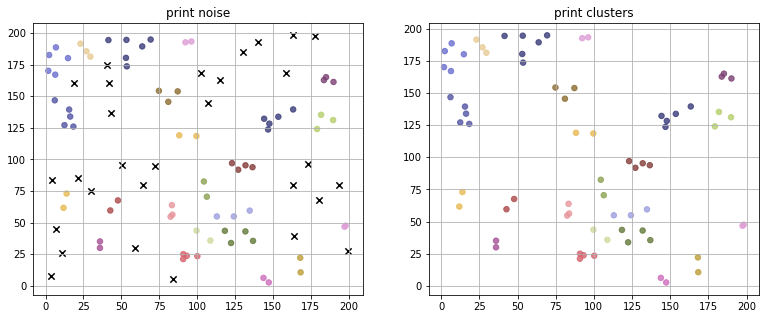

In [14]:
cluster_done = cluster_numbering(row_clusters.copy(), input_range)


plt.figure(figsize=(13,5))
plt.subplot(121)
plt.title('print noise')
plt.scatter(new_X[:,0], new_X[:,1], c=cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.8)
plt.scatter(drop_list[:, 0], drop_list[:, 1], marker = 'x', s=40, color = 'black')
plt.grid(True)


plt.subplot(122)
plt.title('print clusters')
plt.scatter(new_X[:,0], new_X[:,1], c=cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.8)
plt.grid(True)


plt.show()

# 군집별 중앙 값 검색(함수, 정렬, 중심찾기)

In [15]:
def quick_sort(centroid_X):
    def sort(low, high):
        if high <= low:
            return
        
        mid = partition(low, high)
        sort(low, mid - 1)
        sort(mid, high)
    
    def partition(low, high):
        pivot = centroid_X[(low + high) // 2][2]
        while low <= high:
            while centroid_X[low][2] < pivot:
                #print(centroid_X[low][2], low, pivot)
                low += 1
            while centroid_X[high][2] > pivot:
                high -= 1
            if low <= high:
                centroid_X[low][2], centroid_X[high][2] = centroid_X[high][2].copy(), centroid_X[low][2].copy()
                centroid_X[low][1], centroid_X[high][1] = centroid_X[high][1].copy(), centroid_X[low][1].copy()
                centroid_X[low][0], centroid_X[high][0] = centroid_X[high][0].copy(), centroid_X[low][0].copy()
                low, high = low + 1, high - 1
        return low
    
    return sort(0, len(centroid_X) - 1)

def marge_n_sort (input_spot, drop_list, drop_len, new_X, cluster_done):
    # 중앙 좌표 저장을 위한 numpy배열 생성(-1.0으로 모두 채움)
    centroid_X = np.full((input_spot - drop_len,3), -1.0)
    
    #스팟 좌표+소속 군집 번호
    for i in range(input_spot - drop_len):
        centroid_X[i][0] = new_X[i][0]
        centroid_X[i][1] = new_X[i][1]
        centroid_X[i][2] = cluster_done[i]
    
    non_sort_centroid = centroid_X.copy()
    quick_sort(centroid_X)
    
    #노이즈 좌표 + 노이즈 번호(노이즈는 모두 -1)
    for i in range(drop_len):
        non_sort_centroid = np.append(non_sort_centroid, (drop_list[i][0],drop_list[i][1],-1.0))
        centroid_X = np.append(centroid_X, (drop_list[i][0],drop_list[i][1],-1.0))
    
    non_sort_centroid = np.reshape(non_sort_centroid, (input_spot,3))
    centroid_X = np.reshape(centroid_X, (input_spot,3))
    
    return centroid_X, non_sort_centroid

In [16]:
def make_centroid(centroid_X):
    # 중심 좌표 계산
    count = 1
    sumx = sumy = 0.0
    centroid = np.array([])
    shape = 0
    
    for i in range(len(centroid_X)):
        if(centroid_X[i][2] == -1):
            continue
        
        sumx += centroid_X[i][0]
        sumy += centroid_X[i][1]
        count += 1
        if(centroid_X[i][2] != centroid_X[i+1][2]):
            centroid = np.append(centroid, [sumx / float(count-1),sumy / float(count-1)])
            count = 1
            sumx = sumy = 0
            shape = int(centroid_X[i][2])
    
    centroid = np.reshape(centroid, (shape,2))
    
    return centroid

In [17]:
centroid_X, non_sort_centroid = marge_n_sort (input_spot, drop_list, drop_len, new_X, cluster_done)
centroid = make_centroid(centroid_X)
#print(len(centroid))
#print(centroid_X)

# 최종 출력

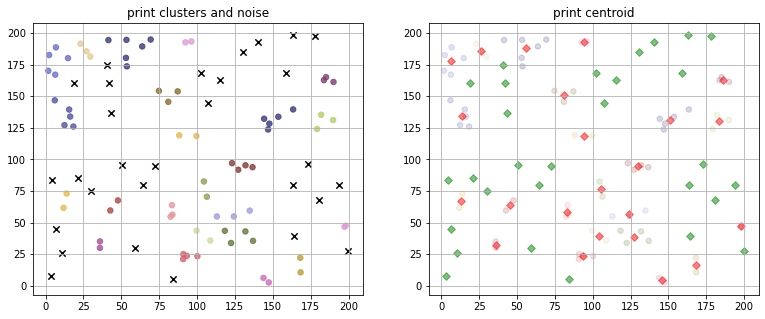

In [18]:
plt.figure(figsize=(13,5))
plt.subplot(121)
plt.title('print clusters and noise')

t=plt.scatter(new_X[:,0], new_X[:,1], c=cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.8)
plt.scatter(drop_list[:, 0], drop_list[:, 1], marker = 'x', s=40, color = 'black')

#plt.scatter(centroid[:,0], centroid[:,1], marker = 'D', s=40, color = 'magenta', alpha = 0.1)
plt.grid(True)



plt.subplot(122)
plt.title('print centroid')

plt.scatter(new_X[:,0], new_X[:,1], c=cluster_done, marker = 'o', s=30, cmap='tab20b', alpha = 0.2)
plt.scatter(drop_list[:, 0], drop_list[:, 1], marker = 'D', s=30, color = 'green', alpha = 0.5)

plt.scatter(centroid[:,0], centroid[:,1], marker = 'D', s=30, color = 'red', alpha = 0.5)
plt.grid(True)



plt.show()

# cenoise (군집 중심 + 노이즈만 합친 넘파이)
그리고 시작점, 끝점도 합쳐줌

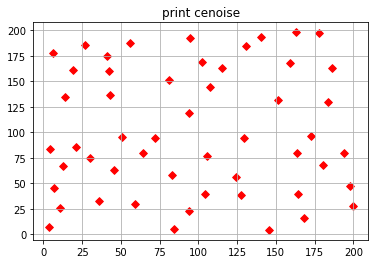

In [19]:
cenoise = np.append(drop_list, centroid)
cenoise = np.reshape(cenoise, (drop_len+len(centroid),2))
plt.title('print cenoise')
plt.scatter(cenoise[:, 0], cenoise[:, 1], marker = 'D', s=30, color = 'red')
plt.grid(True)
plt.show()

# cenoise에 시작점, 끝점 합침
cenoise = np.append(cenoise, SE)
cenoise = np.reshape(cenoise, (drop_len+len(centroid)+SE_n,2))

# coordinate_1 (각 스팟의 이동해야할 위치 배열 저장)

In [20]:
coordinate_1 = np.array([])
for i in range(len(non_sort_centroid)):
    n = int(non_sort_centroid[i][2])
    if(n != -1):
        coordinate_1 = np.append(coordinate_1, centroid[n-1].copy())
    else:
        coordinate_1 = np.append(coordinate_1, non_sort_centroid[i][:2].copy())

coordinate_1 = np.reshape(coordinate_1, (input_spot,2))
#print(coordinate_1)

# 길찾기 전 cenoise노드들 간의 모든 유클리디언 거리 계산

In [21]:
var = ['X', 'Y']
cen_labels = ['cen0']
for i in range(0,len(cenoise)-1):
    z = 'cen'+str(i+1)
    cen_labels.append(z)
        
cenoise_df = pd.DataFrame(cenoise, columns = var, index = cen_labels)
cenoise_row_dist = hierarchical_dendrogram(cenoise_df, cen_labels)

print(cenoise_row_dist.iloc[:5,:5])

row_dist 반환
            cen0        cen1        cen2        cen3        cen4
cen0    0.000000   76.920694  170.491328  197.877846  144.387450
cen1   76.920694    0.000000  175.713173  195.361472  136.040243
cen2  170.491328  175.713173    0.000000   30.375684   43.668017
cen3  197.877846  195.361472   30.375684    0.000000   59.332276
cen4  144.387450  136.040243   43.668017   59.332276    0.000000


# 계산된 유클리디언 거리를 노드1, 노드2, 거리 형식의 numpy로 변환

In [22]:
cenoise_eu = np.array([])

for i in range(len(cenoise)):
    for j in range(len(cenoise)):
        if(i <= j):
            break
        cenoise_eu = np.append(cenoise_eu, [i,j,cenoise_row_dist['cen'+str(i)]['cen'+str(j)]])
        
# 행렬의 크기는 노드수*(노드수-1)/2
m = int(len(cenoise)*(len(cenoise)-1)/2)
cenoise_eu = np.reshape(cenoise_eu, (m,3))

quick_sort(cenoise_eu)
#print(cenoise_eu[:5])

# kruskal 알고리즘(제일 거리가 짧은 선부터 연결)

In [23]:
'''시작점 1개일 때의 경우만 고려함'''

# 시작점과 도착점 각각 가장 먼저 언급 된 선을 찾아서 테이블의 2개의 선으로 따로 삽입함
# 연결된 노드들의 순서가 시작점, 출발점이 가장 처음과 끝이 되도록 하기 위한 작업
def set_point(cenoise_eu, table, len_cenoise):
    found_start = 0
    found_end = 0
    
    for i in range(0,len(cenoise_eu)-1):
        if (found_start + found_end == 2):
            break
            
        m = cenoise_eu[i]
        m0, m1 = int(m[0]), int(m[1])
        
        # 출발점 찾기
        if(m0 == len_cenoise-1 or m1 == len_cenoise-1):
            if (found_start == 0):
                found_start = 1
                m_start = m.copy()
                # 출발점이 항상 왼쪽에 와야 하므로  2가지 경우 다르게 삽입
                if (m0 == len_cenoise-1):
                    table.append([m[0], m[1]])
                else:
                    table.append([m[1], m[0]])
        # 도착점 찾기
        elif(m0 == len_cenoise-2 or m1 == len_cenoise-2):
            if (found_end == 0):
                found_end = 1
                m_end = m.copy()
                # 도착점이 항상 오른쪽에 와야 하므로  2가지 경우 다르게 삽입
                if (m0 == len_cenoise-2):
                    table.append([m[1], m[0]])
                else:
                    table.append([m[0], m[1]])
           
    return table, m_start, m_end

In [24]:
# 싸이클 찾기(싸이클 존재 시 -1 반환, 싸이클 없다면 len(table_num)==0 반환, 싸이클 없고 연결할 노드 위치 찾으면 array 반환)
def find_cycle (table, node):
    count = 0
    table_num = [] # 몇번 째 테이블 행에 연결할 노드가 있는지 반환
    
    # table에 아무것도 없으므로 찾을 싸이클도 없기 때문에 len(table_num)==0 반환
    if(len(table) == 0):
        return table_num
    
    for i in range(len(table)):
        for j in range(len(table[i])):
            if(table[i][j] == node[0] or table[i][j] == node[1]):
                count += 1
            # 싸이클 없고 연결할 노드 찾음
            if(j == len(table[i])-1 and count == 1):
                table_num.append(i)
                count = 0
            # 싸이클 발견
            if(count == 2):
                return -1
    
    return table_num

In [25]:
def connect_line(table, node, table_num = False):
    # 존재하는 집합이 없음으로 테이블에 추가하고 종료
    if(table_num == False):
        table.append([node[0], node[1]])
        return table
        
    # 테이블에 존재하는 노드를 1개만 찾은 경우와 2개 모두를 찾은 경우
    if(len(table_num) == 1):
        k = table_num[0]
        
        # 왼쪽 노드가 집합에 있고 인덱스가 0이면 앞에 오른쪽 노드 삽입, 인덱스가 리스트 끝 이면 맨 뒤에 오른쪽 노드 삽입
        if node[0] in table[k]:
            if(table[k].index(node[0]) == 0):
                table[k].insert(0, node[1])
            else:
                table[k].extend([node[1]])
        else:
            if(table[k].index(node[1]) == 0):
                table[k].insert(0, node[0])
            else:
                table[k].extend([node[0]])
    else:
        l1, l2 = table_num[0], table_num[1]
        
        # 왼쪽 노드가 2개의 집합중 1번에 존재하는지, 2번에 존재하는지 확인
        # 1번에 존재하면 오른쪽 노드는 무조건 2번에 존재하게 됨. 반대도 마찬가지
        if node[0] in table[l1]:
            n1 = table[l1].index(node[0])
            n2 = table[l2].index(node[1])
        elif node[0] in table[l2]:
            n2 = table[l2].index(node[0])
            n1 = table[l1].index(node[1])
            
        # n1과 n2가 같은 경우는 도착 노드와 관계가 있기 때문임
        # 따라서 이 경우 하나의 경로를 거꾸로 뒤집어서 붙여줄 필요가 있음
        if(n1 == n2):
            if (n1 == n2 == 0):
                table[l2].reverse()
                table[l2].extend(table[l1])
                table.remove(table[l1])
            else:
                table[l1].reverse()
                table[l1].extend(table[l2])
                table.remove(table[l2])
            
        # 각 행에서 연결할 노드는 좌우 끝 중 하나임 따라서 하나는 0, 하나는 인덱스 끝 값임
        # 만약 인덱스1(n1)이 인덱스2 보다 작다면 n1==0, n2==end of list 라는 뜻. 
        # n2 뒤에 n1이 붙어야 하므로 붙이고, 뒤에 붙은 집합은 전체 테이블에서 삭제
        elif(n1 < n2):
            table[l2].extend(table[l1])
            table.remove(table[l1])
        else:
            table[l1].extend(table[l2])
            table.remove(table[l2])
    
    return table

In [100]:
# 선 긋고 해당 노드의 tri 리스트에 간선수를 1개씩 더해줌, 최단 경로 산출용 선을 shortest에 삽입
def draw_line(tri, cenoise, m0, m1, m, shortest, doit = True, re = True):
    lin = np.zeros((2,2)) #그래프 간선 출력용 array : line
    
    lin[0] = (cenoise[m0][0], cenoise[m1][0])
    lin[1] = (cenoise[m0][1], cenoise[m1][1])
    
    if(doit == True):
        plt.plot(lin[0], lin[1], marker = 'o', color = 'olive', zorder = 1)
        
    if( re == False):
        return
    
    tri[m0] += 1.0
    tri[m1] += 1.0
    
    shortest = np.append(shortest, m)
    
    return tri, shortest

In [84]:
def kruskal (roop_stop, cenoise_eu, table, tri, cenoise, shortest, len_cenoise, doit = True):
    for i in range(0,len(cenoise_eu)-1):
        if(np.sum(tri) == roop_stop-1):
            break # 모든 연결 끝. 종료
        
        m = cenoise_eu[i]
        m0, m1 = int(m[0]), int(m[1])
        
        # 간선을 연결할 노드 중 하나라도 이미 2개의 간선을 가졌다면 긋지 않고 패스
        # 시작점 노드는 간선 1개만 가져도 패스(시작점 1개일 때와 2개일 때 따로 검사)
        if(tri[m0] == 2.0 or tri[m1] == 2.0):
            continue
        if(m0 == len_cenoise-1 or m1 == len_cenoise-1):
            if(tri[m0] == 1.0 or tri[m1] == 1.0):
                continue
        if(SE_n == 3 and (m0 == len_cenoise-2) or m1 == len_cenoise-2):
            if(tri[m0] == 1.0 or tri[m1] == 1.0):
                continue
        
        # 싸이클 찾기
        table_num = find_cycle(table, m)
        if(table_num == -1):
            continue
        if(len(table_num) == 0):
            table = connect_line(table, m.copy())
        else:
            table = connect_line(table, m.copy(), table_num)
            
        # 선 긋기, 간선 수 더하기, 최단 경로 저장
        tri, shortest = draw_line(tri, cenoise, m0, m1, m, shortest, doit)
    return tri, shortest, table

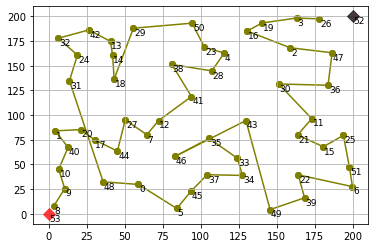

In [101]:
len_cenoise = len(cenoise)

tri = np.zeros([len(cenoise)]) #노드들의 연결 간선 수 저장용 array : triple
shortest = np.array([]) #최단경로 저장용 array : shortest path
table = [] #노드들의 연결 현황을 나타낼 list
e = 0

# 시작.끝을 제외하고 모든 노드는 2개씩의 간선을 가지며 시작.끝은 1개씩만 가짐
# 시작점이 2개라면 끝점의 간선은 2개가 됨. 결국 시작점이 1개 추가되어도 
# 간선 1개를 갖는 노드는 언제나 2개이기 때문에 공식은 항상 똑같이 2를 빼주고 더해줌
roop_stop = 2*(len_cenoise-2)+2

# 출발, 도착점을 셋팅하고 표에 출력
table, m_start, m_end = set_point(cenoise_eu, table, len_cenoise)
tri, shortest = draw_line(tri, cenoise, int(m_start[0]), int(m_start[1]), m_start, shortest, False)
tri, shortest = draw_line(tri, cenoise, int(m_end[0]), int(m_end[1]), m_end, shortest, False)

# kruskal 알고리즘 호출
tri, shortest, table = kruskal(roop_stop, cenoise_eu, table, tri, cenoise, shortest, len_cenoise)

# 최단경로 모아둔 리스트를 정렬
shortest = np.reshape(shortest,(len_cenoise-1,3))

# 노드들(투명), 시작1.시작2.종료(마름모) 추가로 출력 ---- (zorder 수가 높을 수록 상위에 노출됨)
plt.scatter(end_point[0], end_point[1], marker = 'D', s=70, color = 'black', alpha = 0.7, zorder = 2)
plt.scatter(start_point_1[0], start_point_1[1], marker = 'D', s=70, color = 'red', alpha = 0.7, zorder = 2)
#plt.scatter(start_point_2[0], start_point_2[1], marker = 'D', s=50, color = 'cyan', zorder = 2)


for i in range(len(cenoise)):
    str_val = "%s"%(i)
    plt.text(cenoise[i,0]+0.5, cenoise[i,1], str_val, fontsize=9, color='black',
             horizontalalignment = 'left', verticalalignment = 'top')


plt.scatter(cenoise[:, 0], cenoise[:, 1], marker = 'o', s=30, color = 'red', alpha = 0.2)
plt.grid(True)
plt.show()

↓ 확인용 출력(추후 삭제)

In [44]:
testtt = [int(x) for x in table[0]]
print(testtt)
print('최단경로 : ',np.sum(shortest[:,2]))
#print(shortest)

[53, 8, 9, 10, 40, 1, 20, 17, 44, 12, 7, 27, 41, 50, 23, 4, 28, 38, 29, 18, 14, 13, 42, 32, 24, 31, 48, 0, 5, 45, 37, 34, 33, 35, 46, 43, 49, 39, 22, 6, 51, 25, 15, 21, 11, 30, 36, 47, 2, 16, 19, 3, 26, 52]
최단경로 :  1466.7597267251117


# kruskal 연산 후 최 장거리 부터 다시 연산

In [136]:
# 마지막 간선을 찾아서 해당 위치까지 array 복사
reverse_list = np.array([])
for i in range(len(cenoise_eu)):
    if(cenoise_eu[i][2] == shortest[-1][2]):
        reverse_list = cenoise_eu[:i,:].copy()
        break

for_list = []
for_dist = []
for_short = []
for i in tqdm(range(len(reverse_list))):
    tri_re = np.zeros([len(cenoise)]) #노드들의 연결 간선 수 저장용 array : triple
    shortest_re = np.array([]) #최단경로 저장용 array : shortest path
    table_re = [] #노드들의 연결 현황을 나타낼 list
    e = 0
    
    # 출발, 도착점을 셋팅하고 표에 출력
    table_re, m_start, m_end = set_point(cenoise_eu, table_re, len_cenoise)
    tri_re, shortest_re = draw_line(tri_re, cenoise, int(m_start[0]), int(m_start[1]), m_start, shortest_re, False)
    tri_re, shortest_re = draw_line(tri_re, cenoise, int(m_end[0]), int(m_end[1]), m_end, shortest_re, False)
    
    # 최장 거리 선 하나 미리 넣기
    m = reverse_list[len(reverse_list) - 1 - i]
    m0, m1 = int(m[0]), int(m[1])
    
    if(tri_re[m0] == 2.0 or tri_re[m1] == 2.0):
        continue
    if(m0 == len_cenoise-1 or m1 == len_cenoise-1):
        if(tri_re[m0] == 1.0 or tri_re[m1] == 1.0):
            continue
    if(SE_n == 3 and (m0 == len_cenoise-2) or m1 == len_cenoise-2):
        if(tri_re[m0] == 1.0 or tri_re[m1] == 1.0):
            continue
    
    table_num_re = find_cycle(table_re, m)
    if(table_num_re == -1):
        print(i, " 번은 개인주의야")
        continue
    if(len(table_num_re) == 0):
        table_re = connect_line(table_re, m.copy())
    else:
        table_re = connect_line(table_re, m.copy(), table_num_re)
    
    # 선 긋기, 간선 수 더하기, 최단 경로 저장
    tri_re, shortest_re = draw_line(tri_re, cenoise, m0, m1, m, shortest_re, False)
    
    # kruskal 알고리즘 호출
    tri_re, shortest_re, table_re = kruskal(roop_stop, cenoise_eu, table_re, tri_re, cenoise, shortest_re, len_cenoise, False)
    
    b = 0
    for j in range(len(tri_re)):
        if tri_re[j] == 0:
            b = -1
    if b == -1:
        continue
    
    # 최단경로 모아둔 리스트를 정렬
    shortest_re = np.reshape(shortest_re,(len_cenoise - 1, 3))
    
    testtt = [int(x) for x in table_re[0]]
    
    for_list.append(testtt)
    for_short.append(shortest_re)
    for_dist.append(np.sum(shortest_re[:,2]))

 97%|████████████████████████████████████████████████████████████████████████████▋  | 603/621 [00:05<00:00, 103.24it/s]

592  번은 개인주의야


100%|███████████████████████████████████████████████████████████████████████████████| 621/621 [00:06<00:00, 102.63it/s]


593
최단거리 :  1427.495008187754
최단경로 :  [53, 8, 9, 10, 40, 17, 20, 1, 18, 14, 13, 42, 32, 24, 31, 29, 50, 23, 4, 28, 38, 41, 12, 7, 27, 44, 48, 0, 5, 45, 37, 34, 33, 35, 46, 43, 49, 39, 22, 6, 51, 25, 15, 21, 11, 30, 36, 47, 2, 16, 19, 3, 26, 52]


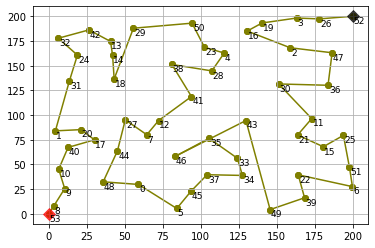

In [135]:
w = for_dist[0]
c = 0
for i in range(1,len(for_dist)):
    if(w>for_dist[i]):
        w = for_dist[i]
        c = i
               
print(c)
print('최단거리 : ', for_dist[c])
print('최단경로 : ', for_list[c])


# 노드들(투명), 시작1.시작2.종료(마름모) 추가로 출력 ---- (zorder 수가 높을 수록 상위에 노출됨)
plt.scatter(end_point[0], end_point[1], marker = 'D', s=70, color = 'black', alpha = 0.7, zorder = 2)
plt.scatter(start_point_1[0], start_point_1[1], marker = 'D', s=70, color = 'red', alpha = 0.7, zorder = 2)
#plt.scatter(start_point_2[0], start_point_2[1], marker = 'D', s=50, color = 'cyan', zorder = 2)

for i in range(len_cenoise - 1):
    m = for_short[c][i]
    draw_line(False, cenoise, int(m[0]), int(m[1]), m, False, True, False)

for i in range(len(cenoise)):
    str_val = "%s"%(i)
    plt.text(cenoise[i,0]+0.5, cenoise[i,1], str_val, fontsize=9, color='black',
             horizontalalignment = 'left', verticalalignment = 'top')


plt.scatter(cenoise[:, 0], cenoise[:, 1], marker = 'o', s=30, color = 'red', alpha = 0.2)
plt.grid(True)
plt.show()

# 문제점 혹은 의문점
현재 최단경로에서 출발점과 도착점이 실제 연산된 시작점, 끝점이 아님. 크루스칼로 연산되어서 출발과 도착점의 인덱스가 경로 중간에 삽입되는 상황인데, 이를 수정하여 출발점 == 시작점, 도착점 == 끝점 으로 한다면 결과가 달라질 수 있음.
사용된 데이터의 가정이 출발점 == (0,0), 도착점 == (200,200) 이므로 크게 다르지 않아 보이지만 두 점이 랜덤한 위치라면 다른 결과가 나올 수 있음.
--> 해결함

## 이하 내용은 참고자료 혹은 백업 자료

In [73]:
from tqdm import tqdm